# Getting Started

Pandas-TD allows you to read a query result into a DataFrame and to store a DataFrame to Treasure Data.

Before starting any session, you need to set your API key to the environment variable ``TD_API_KEY``:

    export TD_API_KEY=1234/abcd...

You can initialize your connection by ``connect``:

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import pandas_td as td

# Initialize connection
con = td.connect(apikey=os.environ['TD_API_KEY'], endpoint='https://api.treasuredata.com/')

Using a connection, you can use some convenient methods like ``databases`` and ``tables``:

In [2]:
# Get a list of databases
con.databases()

,name,count,permission,created_at,updated_at
0,tutorial,19,full_access,2015-05-27 13:12:43+00:00,2015-05-27 13:12:43+00:00
1,sample_datasets,8812278,query_only,2014-10-04 01:13:11+00:00,2015-01-09 01:07:14+00:00


In [3]:
# Get a list of tables
con.tables('sample_datasets')

,name,count,estimated_storage_size,last_log_timestamp,created_at
0,nasdaq,8807278,168205061,1970-01-01 00:00:00+00:00,2014-10-08 02:57:38+00:00
1,www_access,5000,0,2014-10-04 01:13:15+00:00,2014-10-04 01:13:12+00:00


You can choose a query engine and use it to run a queby by ``read_td``:

In [4]:
# Select a query engine
presto = con.query_engine(database='sample_datasets', type='presto')

# Run a query
td.read_td('select * from nasdaq limit 3', presto)

,symbol,open,volume,high,low,close,time
0,LINC,4.20,373825,4.60,4.16,4.49,1404144000
1,KBIO,2.32,490796,2.45,2.26,2.28,1404144000
2,ISIL,15.02,1694883,15.06,14.84,14.95,1404144000


Alternatively, you can read a table into a DataFrame by ``read_td_table``, optionally with a specific time range, sample rate, and/or a limit:

In [5]:
# Read from a table with 5-percent sampling
df = td.read_td_table('nasdaq', presto, time_range=('2000-01-01', '2010-01-01'), sample=0.05, limit=10000)

Pandas-TD also supports importing a DataFrame into a table by ``to_td``:

In [6]:
# Create a DataFrame with random values
df = pd.DataFrame(np.random.rand(3, 3), columns=['x', 'y', 'z'])

# Import it into 'tutorial.tut1'
td.to_td(df, 'tutorial.tut1', con, if_exists='replace', index=False)

In [7]:
# Check the result
td.read_td('select * from tutorial.tut1', presto)

,z,y,x,time
0,0.579276,0.729514,0.984005,1432999247
1,0.265180,0.693649,0.316524,1432999247
2,0.898841,0.794635,0.518262,1432999247


# read_td_query

In [8]:
help(td.read_td_query)

Help on function read_td_query in module pandas_td.td:

read_td_query(query, engine, index_col=None, params=None, parse_dates=None)
    Read Treasure Data query into a DataFrame.
    
    Returns a DataFrame corresponding to the result set of the query string.
    Optionally provide an index_col parameter to use one of the columns as
    the index, otherwise default integer index will be used.
    
    Parameters
    ----------
    query : string
        Query string to be executed.
    engine : QueryEngine
        Handler returned by Connection.query_engine.
    index_col : string, optional
        Column name to use as index for the returned DataFrame object.
    params : dict, optional
        Parameters to pass to execute method.
    parse_dates : list or dict, optional
        - List of column names to parse as dates
        - Dict of {column_name: format string} where format string is strftime
          compatible in case of parsing string times or is one of (D, s, ns, ms, us)
  

### Examples

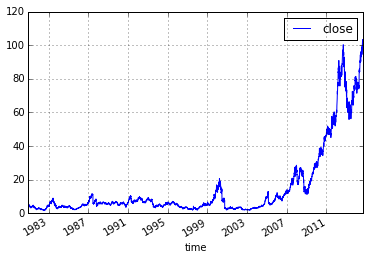

In [9]:
# Convert "time" to a time series index
df = td.read_td_query("select time, close from nasdaq where symbol='AAPL'",
                      presto,
                      index_col='time',
                      parse_dates={'time': 's'})
df.plot()

# read_td_table

In [10]:
help(td.read_td_table)

Help on function read_td_table in module pandas_td.td:

read_td_table(table_name, engine, index_col=None, parse_dates=None, columns=None, time_range=None, sample=None, limit=10000)
    Read Treasure Data table into a DataFrame.
    
    The number of returned rows is limited by "limit" (default 10,000).
    Setting limit=None means all rows. Be careful when you set limit=None
    because your table might be very large and the result does not fit into memory.
    
    Parameters
    ----------
    table_name : string
        Name of Treasure Data table in database.
    engine : QueryEngine
        Handler returned by Connection.query_engine.
    index_col : string, optional
        Column name to use as index for the returned DataFrame object.
    parse_dates : list or dict, optional
        - List of column names to parse as dates
        - Dict of {column_name: format string} where format string is strftime
          compatible in case of parsing string times or is one of (D, s, ns, m

### Examples

In [11]:
# Read all records (up to 10,000 rows by default)
df = td.read_td_table("www_access", presto)
df.head(3)

,user,host,path,referer,code,agent,size,method,time
0,None,192.225.229.196,/category/software,-,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,117,GET,1412382292
1,None,120.168.215.131,/category/software,-,200,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,53,GET,1412382284
2,None,180.198.173.136,/category/electronics,/category/computers,200,Mozilla/5.0 (Windows NT 6.0) AppleWebKit/535.1...,106,GET,1412382275


In [12]:
# From 1990 to 2010, 1-percent sample, no limit
df = td.read_td_table("nasdaq",
                      presto,
                      index_col='time',
                      parse_dates={'time': 's'},
                      columns=['time', 'symbol', 'close'],
                      time_range=('1990', '2010'),
                      sample=0.01,
                      limit=None)
len(df)

55136

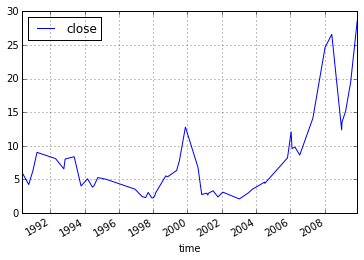

In [13]:
df[df.symbol=='AAPL'].plot()

# to_td

In [14]:
help(td.to_td)

Help on function to_td in module pandas_td.td:

to_td(frame, name, con, if_exists='fail', time='now', index=True, index_label=None, chunksize=10000)
    Write a DataFrame to a Treasure Data table.
    
    This method converts the dataframe into a series of key-value pairs
    and send them using the Treasure Data streaming API. The data is divided
    into chunks of rows (default 10,000) and uploaded separately. If upload
    failed, the client retries the process for a certain amount of time
    (max_cumul_retry_delay; default 600 secs). This method may fail and
    raise an exception when retries did not success, in which case the data
    may be partially inserted. Use the bulk import utility if you cannot
    accept partial inserts.
    
    Parameters
    ----------
    frame : DataFrame
        DataFrame to be written.
    name : string
        Name of table to be written, in the form 'database.table'.
    con : Connection
        Connection to a Treasure Data account.
    if_ex

### Examples

In [15]:
# Create a DataFrame with random values
df = pd.DataFrame(np.random.rand(3, 3), columns=['x', 'y', 'z'])

``to_td`` will fail if table already exists:

In [16]:
td.to_td(df, 'tutorial.tut1', con)

RuntimeError: table "tutorial.tut1" already exists

In [17]:
# Set "if_exists" to 'replace' or 'append'
td.to_td(df, 'tutorial.tut1', con, if_exists='replace')

Use index=False if you don't need to insert DataFrame index:

In [18]:
td.to_td(df, 'tutorial.tut1', con, if_exists='replace', index=False)

``to_td`` inserts the current time as "time" column (time='now').  You can change it by "time" parameter:

In [19]:
import datetime

# Set "time" column explicitly
df['time'] = datetime.datetime.now()

# Set time='column' to use "time" as the time column in Treasure Data
td.to_td(df, 'tutorial.tut1', con, if_exists='replace', index=False, time='column')